Dataset Shape: (81, 13)
Epoch 1/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - loss: 7.8051 - mae: 8.3051 - val_loss: 7.5997 - val_mae: 8.0997 - learning_rate: 3.0000e-04
Epoch 2/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.8451 - mae: 8.3451 - val_loss: 7.5886 - val_mae: 8.0886 - learning_rate: 3.0000e-04
Epoch 3/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.7159 - mae: 8.2159 - val_loss: 7.5790 - val_mae: 8.0790 - learning_rate: 3.0000e-04
Epoch 4/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.7580 - mae: 8.2580 - val_loss: 7.5711 - val_mae: 8.0711 - learning_rate: 3.0000e-04
Epoch 5/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.5819 - mae: 8.0795 - val_loss: 7.5562 - val_mae: 8.0562 - learning_rate: 3.0000e-04
Epoch 6/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.7389 - mae: 8.2389 - val_loss: 7.5536 - val_mae: 8.0536 - learning_rate: 3.0000e-04
Epoch 7/700
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 7.5824 - mae: 8.0824 - val_loss: 7.5669 - val_mae: 8.

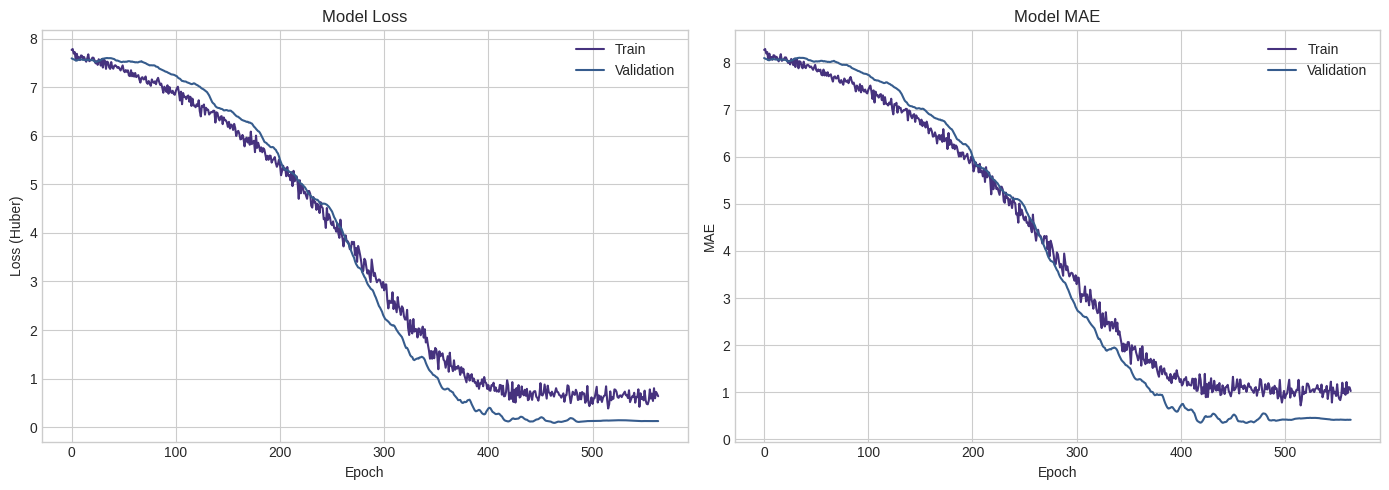

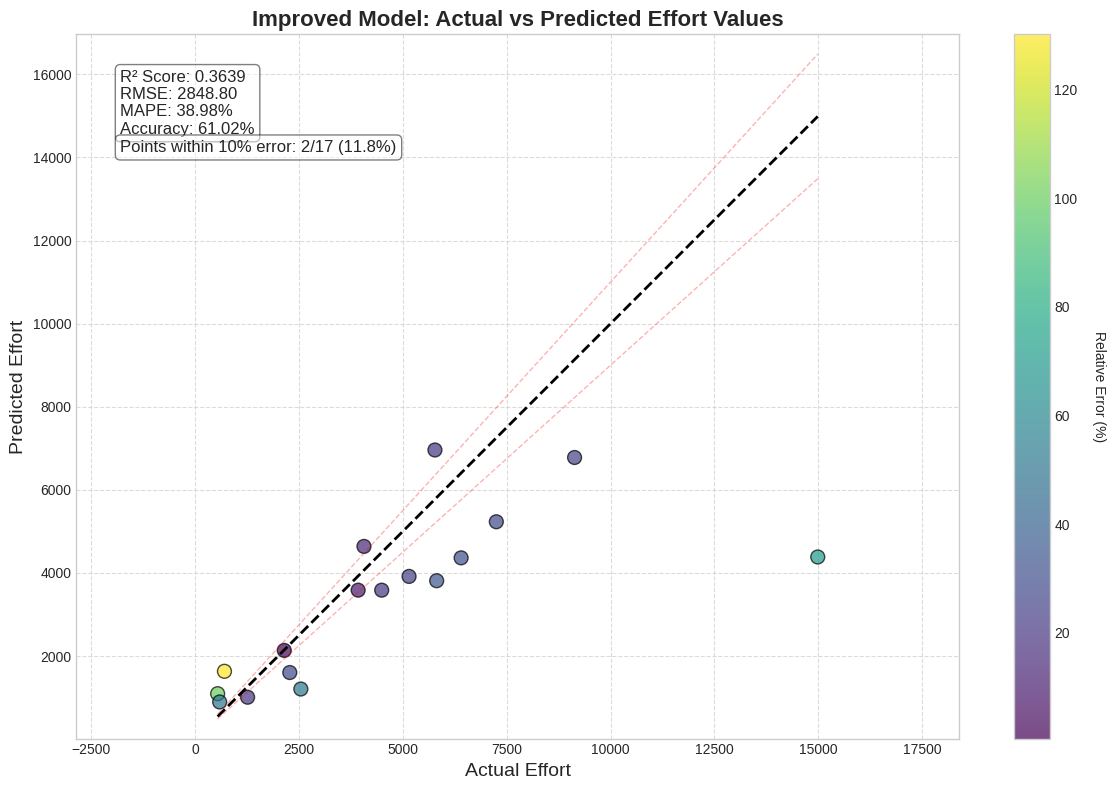

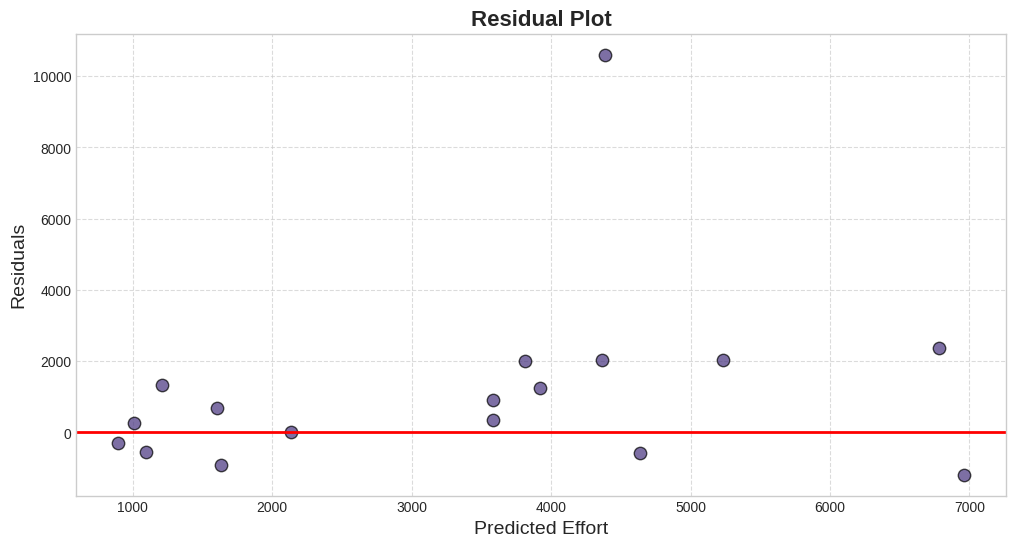

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
df = pd.read_csv("costeffortdataset.csv")
print("Dataset Shape:", df.shape)

# Log transform the target variable to handle skewness
df['Effort_Log'] = np.log1p(df['Effort'])

# Use only the significant features specified
selected_features = ['PointsAjust', 'PointsNonAdjust', 'Length', 'Transactions', 'Entities', 'Adjustment']

# Add a few carefully selected engineered features that help with prediction
df['PointsPerMonth'] = df['PointsAjust'] / df['Length'].replace(0, 1)  # Productivity rate
df['TransactionDensity'] = df['Transactions'] / df['Entities'].replace(0, 1)  # Complexity indicator
df['AdjustmentRatio'] = df['Adjustment'] / 100  # Normalize adjustment factor

# Add these engineered features to the selected features
selected_features += ['PointsPerMonth', 'TransactionDensity', 'AdjustmentRatio']

# Prepare data for modeling
X = df[selected_features].values
y = df['Effort'].values
y_log = df['Effort_Log'].values

# Train-test split with fixed random state for reproducibility
X_train, X_test, y_train, y_test, y_log_train, y_log_test = train_test_split(
    X, y, y_log, test_size=0.2, random_state=42)

# Scale the features using RobustScaler (handles outliers better)
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

# We'll use log-transformed target for better prediction
X_train_final = X_train_scaled
X_test_final = X_test_scaled
y_train_final = y_log_train
y_test_final = y_log_test

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Function to build the deep learning model
def create_improved_model(input_dim):
    model = Sequential()

    # First layer - capture feature interactions
    model.add(Dense(128, activation='selu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Second layer with moderate narrowing
    model.add(Dense(64, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Third layer for further abstraction
    model.add(Dense(32, activation='selu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Output layer - linear activation for regression
    model.add(Dense(1))

    # Use Adam optimizer with a moderately low learning rate
    optimizer = Adam(learning_rate=0.0003)

    # Compile with Huber loss for robustness against outliers
    model.compile(loss='huber', optimizer=optimizer, metrics=['mae'])

    return model

# Create and compile the model
input_dim = X_train_final.shape[1]
model = create_improved_model(input_dim)

# Set up callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=30,
    min_lr=0.000001,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_final, y_train_final,
    epochs=700,
    batch_size=25,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (Huber)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('training_history.png')

# Predict on test set (log scale)
y_pred_log = model.predict(X_test_final).flatten()

# Convert back from log scale
y_pred = np.expm1(y_pred_log)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = max(0, 100 - mape)  # Regression accuracy as 100 - MAPE

print("\nFinal Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Regression Accuracy: {accuracy:.2f}%")

# Create actual vs predicted plot
plt.figure(figsize=(12, 8))

# Calculate relative errors for coloring the points
relative_errors = np.abs((y_test - y_pred) / y_test) * 100

# Create scatter plot with color based on relative error
scatter = plt.scatter(y_test, y_pred,
                     alpha=0.7,
                     c=relative_errors,
                     cmap='viridis',
                     s=100,
                     edgecolors='k',
                     linewidths=1)

# Add the identity line (perfect predictions)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2,
         label='Perfect Prediction')

# Add text box with metrics
textstr = '\n'.join((
    f'R² Score: {r2:.4f}',
    f'RMSE: {rmse:.2f}',
    f'MAPE: {mape:.2f}%',
    f'Accuracy: {accuracy:.2f}%'))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=props)

# Add 10% error margins
for margin in [0.9, 1.1]:
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min()*margin, y_test.max()*margin],
             'r--', alpha=0.3,
             linewidth=1)

# Add colorbar to show relative error
cbar = plt.colorbar(scatter)
cbar.set_label('Relative Error (%)', rotation=270, labelpad=20)

# Add labels and title
plt.title('Improved Model: Actual vs Predicted Effort Values', fontsize=16, fontweight='bold')
plt.xlabel('Actual Effort', fontsize=14)
plt.ylabel('Predicted Effort', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.tight_layout()

# Add prediction points within 10% error bands text
points_within_10pct = sum(relative_errors <= 10)
total_points = len(relative_errors)
plt.text(0.05, 0.85,
         f'Points within 10% error: {points_within_10pct}/{total_points} ({points_within_10pct/total_points*100:.1f}%)',
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=props)

plt.savefig('improved_actual_vs_predicted.png', dpi=300)

# Create a residual plot
plt.figure(figsize=(12, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7, s=80, edgecolors='k', linewidths=1)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.title('Residual Plot', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Effort', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('residual_plot.png', dpi=300)